# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

8.79719785675954 [[ 1.61599406  0.          2.76252524]
 [-0.         -0.5060347  -0.94302519]]
Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут хранить через специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

-0.004183799298012673 [[ 4.18948095e-04  1.76337767e-03 -3.49979411e-04]
 [ 7.82747412e-05 -6.12293143e-04 -1.09946675e-03]]
Gradient check passed!
0.020193253953970248 [[-1.67429365  2.15318718 -0.15893916 -0.56958173]
 [ 3.34858731 -4.30637437  0.31787831  1.13916345]
 [-0.36258122  5.45842018 -3.37773459 -0.89339967]]
Gradient check passed!
-0.010845684739433061 [[-0.632844   -0.39002832  1.75340995  0.51081366]]
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
print(train_X[:2])
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

[[ 0.01928431  0.01804039 -0.01157216 ... -0.02569451 -0.04007804
  -0.1002851 ]
 [ 0.06634314  0.06509922  0.02764353 ...  0.07626627  0.08149059
   0.08010706]]
Checking gradient for W-1
2.3026312169244934 [[-4.41422696e-05  2.82714431e-05  0.00000000e+00]
 [-4.33662620e-05  2.77413588e-05  0.00000000e+00]
 [-1.95407878e-05  1.17800047e-05  0.00000000e+00]
 ...
 [-5.35466370e-05  3.25000856e-05  0.00000000e+00]
 [-5.79535999e-05  3.47263730e-05  0.00000000e+00]
 [-6.05339860e-05  3.41367962e-05  0.00000000e+00]]
Gradient check passed!
Checking gradient for B-1
2.3026312169244934 [[-0.00062384  0.00042614  0.        ]]
Gradient check passed!
Checking gradient for W-2
2.3026312169244934 [[ 0.         -0.00315483  0.00056304  0.          0.          0.00056226
   0.00056212  0.          0.00056252  0.00056234]
 [ 0.         -0.00197476  0.00021971  0.          0.          0.0002194
   0.00021935  0.          0.00021951  0.00021943]
 [ 0.          0.          0.          0.          0.  

True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [8]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e-1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W-1
2.303106550005873 [[ 1.82862903e-04  9.13639818e-05  1.13175289e-04]
 [ 7.23341478e-07  2.26379901e-04 -2.58238842e-04]
 [-2.16387124e-04  2.05188543e-04 -6.11826773e-05]
 ...
 [ 4.00973594e-04  1.69702093e-04 -1.58354812e-04]
 [ 2.22156344e-05 -8.94096278e-05 -1.33803169e-04]
 [ 9.95018455e-06 -9.38783008e-05  3.27460390e-04]]
Gradient check passed!
Checking gradient for B-1
2.303106546741269 [[-0.00021485  0.00021547  0.00060732]]
Gradient check passed!
Checking gradient for W-2
2.3031065406780313 [[ 1.75296289e-04  2.97257598e-04 -7.43164968e-05 -2.64114970e-05
   4.16656230e-04 -1.19913428e-04 -4.36925834e-05 -8.29680546e-05
   4.31110767e-04 -2.12697303e-04]
 [ 2.09727132e-04  2.80450151e-04 -1.09853783e-04 -1.88194710e-03
   2.38741257e-05  1.37745667e-04  8.07645088e-05  2.88658591e-04
  -1.05199501e-04 -1.07170250e-04]
 [ 3.95756907e-04  3.75402270e-04 -6.37434161e-04 -3.02661402e-03
   2.16089250e-04  1.14880839e-04  5.09414859e-04 -2.99161621e-04
   

True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [9]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

7  out of  30


0.23333333333333334

# Допишем код для процесса тренировки

In [10]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD())

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

1020  out of  9000
118  out of  1000
Loss: 2.330731, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.326012, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.322076, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.318793, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.316053, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.313767, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.311859, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.310267, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.308938, Train accuracy: 0.113333, val accuracy: 0.118000
1020  out of  9000
118  out of  1000
Loss: 2.307828, Train accuracy: 0.113333, val

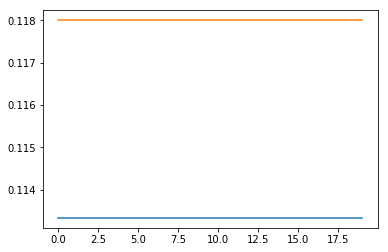

In [11]:
plt.plot(train_history)
plt.plot(val_history)

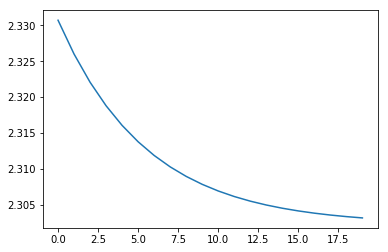

In [12]:
plt.plot(loss_history)

In [ ]:
class Layer:
    def forward(self, x):
        result = ... # промежуточные вычисления
        self.x = x # сохраняем значения, которые нам
                   # понадобятся при обратном проходе
        return result
    
    def backward(self, grad):
        dx = ... # используем сохраненные значения, чтобы 
        dw = ... # вычислить градиент по x и по w
        self.w.grad += dw # аккумулируем градиент dw
        return dx

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [13]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

1299  out of  9000
123  out of  1000
Loss: 2.329992, Train accuracy: 0.144333, val accuracy: 0.123000
1731  out of  9000
195  out of  1000
Loss: 2.321934, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.314828, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.309126, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.304534, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.300825, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.297820, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.295379, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.293391, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.291764, Train accuracy: 0.192333, val

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.97)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

1731  out of  9000
195  out of  1000
Loss: 2.293775, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.291191, Train accuracy: 0.192333, val accuracy: 0.195000
1299  out of  9000
123  out of  1000
Loss: 2.290431, Train accuracy: 0.144333, val accuracy: 0.123000
1731  out of  9000
195  out of  1000
Loss: 2.290817, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.291098, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.289473, Train accuracy: 0.192333, val accuracy: 0.195000
1478  out of  9000
163  out of  1000
Loss: 2.293648, Train accuracy: 0.164222, val accuracy: 0.163000
1731  out of  9000
195  out of  1000
Loss: 2.290224, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.289199, Train accuracy: 0.192333, val accuracy: 0.195000
1731  out of  9000
195  out of  1000
Loss: 2.289006, Train accuracy: 0.192333, val

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [14]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

2  out of  15
4  out of  15
Loss: 2.332068, Train accuracy: 0.133333, val accuracy: 0.266667
2  out of  15
4  out of  15
Loss: 2.323204, Train accuracy: 0.133333, val accuracy: 0.266667
2  out of  15
4  out of  15
Loss: 2.312633, Train accuracy: 0.133333, val accuracy: 0.266667
2  out of  15
4  out of  15
Loss: 2.306108, Train accuracy: 0.133333, val accuracy: 0.266667
2  out of  15
4  out of  15
Loss: 2.301877, Train accuracy: 0.133333, val accuracy: 0.266667
2  out of  15
4  out of  15
Loss: 2.295655, Train accuracy: 0.133333, val accuracy: 0.266667
3  out of  15
3  out of  15
Loss: 2.280810, Train accuracy: 0.200000, val accuracy: 0.200000
3  out of  15
3  out of  15
Loss: 2.217970, Train accuracy: 0.200000, val accuracy: 0.200000
3  out of  15
3  out of  15
Loss: 2.147799, Train accuracy: 0.200000, val accuracy: 0.200000
5  out of  15
4  out of  15
Loss: 2.136381, Train accuracy: 0.333333, val accuracy: 0.266667
5  out of  15
3  out of  15
Loss: 2.102211, Train accuracy: 0.333333, 

13  out of  15
2  out of  15
Loss: 1.875309, Train accuracy: 0.866667, val accuracy: 0.133333
13  out of  15
2  out of  15
Loss: 1.822894, Train accuracy: 0.866667, val accuracy: 0.133333
12  out of  15
2  out of  15
Loss: 1.877571, Train accuracy: 0.800000, val accuracy: 0.133333
14  out of  15
2  out of  15
Loss: 1.709725, Train accuracy: 0.933333, val accuracy: 0.133333
14  out of  15
2  out of  15
Loss: 1.731571, Train accuracy: 0.933333, val accuracy: 0.133333
14  out of  15
2  out of  15
Loss: 1.686091, Train accuracy: 0.933333, val accuracy: 0.133333
14  out of  15
2  out of  15
Loss: 1.617844, Train accuracy: 0.933333, val accuracy: 0.133333
12  out of  15
1  out of  15
Loss: 1.571568, Train accuracy: 0.800000, val accuracy: 0.066667
10  out of  15
2  out of  15
Loss: 2.217303, Train accuracy: 0.666667, val accuracy: 0.133333
13  out of  15
2  out of  15
Loss: 1.877839, Train accuracy: 0.866667, val accuracy: 0.133333
13  out of  15
2  out of  15
Loss: 1.867276, Train accuracy:

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [16]:
def keywithmaxval(d):
     """ a) create a list of the dict's keys and values; 
         b) return the key with the max value"""  
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]

In [25]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

learning_rates = [1e-1, 1e-2, 1e-3, 1e-4]
reg_strengths = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
l_r_to_accuracy = {}

for l in learning_rates:
    for r in reg_strengths:

        model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 110, reg = r)
        # TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
        dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
        trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=l, learning_rate_decay=0.97, num_epochs=20, batch_size=5)
        loss_history, train_history, val_history = trainer.fit()
        l_r_to_accuracy[str(l) + ', ' + str(r)] = np.average(train_history)
        print("Neural Network with l = %e, r = %e" % (l, r))
        print("Accuracy on training set: %4.2f" % (l_r_to_accuracy[str(l) + ', ' + str(r)])) 
        #plt.plot(train_history)
        #plt.plot(val_history)

key_of_best = keywithmaxval(l_r_to_accuracy)
print(keywithmaxval(l_r_to_accuracy), ' accuracy is ', (l_r_to_accuracy[key_of_best]))

3  out of  15
2  out of  15
Loss: 2.334499, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.312168, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.288021, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.272994, Train accuracy: 0.200000, val accuracy: 0.133333
4  out of  15
2  out of  15
Loss: 2.270328, Train accuracy: 0.266667, val accuracy: 0.133333
6  out of  15
1  out of  15
Loss: 2.202071, Train accuracy: 0.400000, val accuracy: 0.066667
6  out of  15
1  out of  15
Loss: 2.118320, Train accuracy: 0.400000, val accuracy: 0.066667
5  out of  15
1  out of  15
Loss: 2.090990, Train accuracy: 0.333333, val accuracy: 0.066667
6  out of  15
1  out of  15
Loss: 2.038735, Train accuracy: 0.400000, val accuracy: 0.066667
6  out of  15
2  out of  15
Loss: 1.996051, Train accuracy: 0.400000, val accuracy: 0.133333
6  out of  15
1  out of  15
Loss: 1.983950, Train accuracy: 0.400000, 

4  out of  15
2  out of  15
Loss: 1.920044, Train accuracy: 0.266667, val accuracy: 0.133333
4  out of  15
1  out of  15
Loss: 1.897172, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
1  out of  15
Loss: 1.855809, Train accuracy: 0.266667, val accuracy: 0.066667
4  out of  15
0  out of  15
Loss: 1.850844, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.847112, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.844938, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.844616, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.843798, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.843442, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.843191, Train accuracy: 0.266667, val accuracy: 0.000000
4  out of  15
0  out of  15
Loss: 1.842999, Train accuracy: 0.266667, 

3  out of  15
0  out of  15
Loss: 2.275043, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.274116, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.272258, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.270011, Train accuracy: 0.200000, val accuracy: 0.000000
Neural Network with l = 1.000000e-02, r = 1.000000e-03
Accuracy on training set: 0.20
3  out of  15
0  out of  15
Loss: 2.303001, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.300590, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.297912, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.294514, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.290238, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.286398, Train accuracy: 0.200000, val acc

3  out of  15
2  out of  15
Loss: 2.305927, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.305697, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.305619, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.305282, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.305000, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.304918, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.304570, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.304383, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.304199, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.303901, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.303726, Train accuracy: 0.200000, 

3  out of  15
2  out of  15
Loss: 2.298539, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.297985, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.297593, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.297107, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.296622, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.296159, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.295796, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.295306, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.294919, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.294534, Train accuracy: 0.200000, val accuracy: 0.133333
3  out of  15
2  out of  15
Loss: 2.294013, Train accuracy: 0.200000, 

3  out of  15
0  out of  15
Loss: 2.302065, Train accuracy: 0.200000, val accuracy: 0.000000
3  out of  15
0  out of  15
Loss: 2.302038, Train accuracy: 0.200000, val accuracy: 0.000000
Neural Network with l = 1.000000e-04, r = 1.000000e-04
Accuracy on training set: 0.20
1  out of  15
1  out of  15
Loss: 2.302830, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302818, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302784, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302715, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302670, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302593, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302566, Train accuracy: 0.066667, val accuracy: 0.066667
1  out of  15
1  out of  15
Loss: 2.302493, Train accuracy: 0.066667, val acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [42]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64
learning_rate_history = []
#reg = 0.01
#learning_rate=0.1

'''
BEST OF THE BEST RECOMMENDED FOR EVERY DATA SCIENTIST!!!
best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 110, reg = 1e-6)
dataset = Dataset(train_X, train_y, val_X, val_y)
best_trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.97, num_epochs=50, batch_size=64)
loss_history, train_history, val_history, learning_rate_history = best_trainer.fit()
'''

best_classifier = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 110, reg = 1e-6)
dataset = Dataset(train_X, train_y, val_X, val_y)
best_trainer = Trainer(best_classifier, dataset, MomentumSGD(), learning_rate=1e-1, learning_rate_decay=0.97, num_epochs=20, batch_size=64)
loss_history, train_history, val_history, learning_rate_history = best_trainer.fit()

best_val_accuracy = np.average(val_history)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

1413  out of  9000
131  out of  1000
Loss: 2.279843, Train accuracy: 0.157000, val accuracy: 0.131000
2602  out of  9000
278  out of  1000
Loss: 2.167154, Train accuracy: 0.289111, val accuracy: 0.278000
2814  out of  9000
288  out of  1000
Loss: 1.984409, Train accuracy: 0.312667, val accuracy: 0.288000
2218  out of  9000
222  out of  1000
Loss: 1.975413, Train accuracy: 0.246444, val accuracy: 0.222000
3059  out of  9000
313  out of  1000
Loss: 1.920605, Train accuracy: 0.339889, val accuracy: 0.313000
2896  out of  9000
297  out of  1000
Loss: 1.870566, Train accuracy: 0.321778, val accuracy: 0.297000
3172  out of  9000
332  out of  1000
Loss: 1.814318, Train accuracy: 0.352444, val accuracy: 0.332000
3256  out of  9000
338  out of  1000
Loss: 1.825201, Train accuracy: 0.361778, val accuracy: 0.338000
3278  out of  9000
353  out of  1000
Loss: 1.781084, Train accuracy: 0.364222, val accuracy: 0.353000
3367  out of  9000
346  out of  1000
Loss: 1.782331, Train accuracy: 0.374111, val

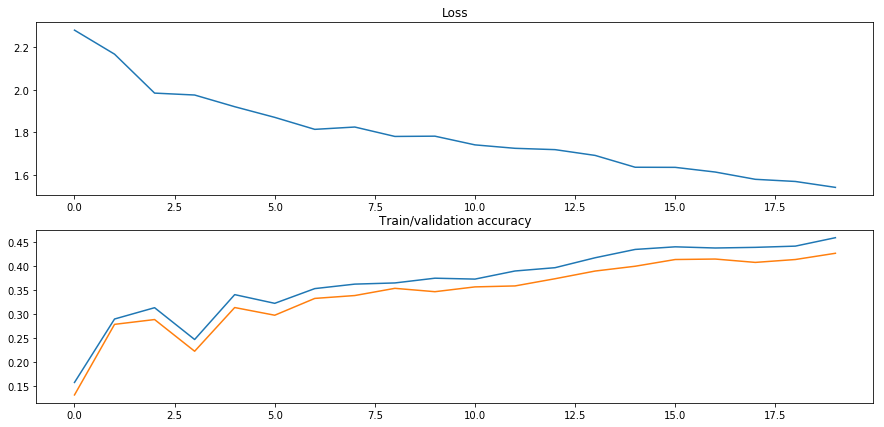

In [43]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

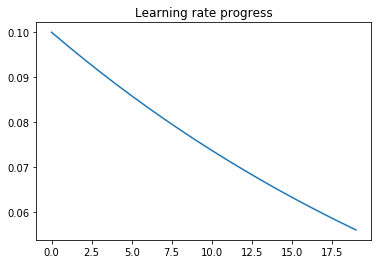

In [44]:
plt.title("Learning rate progress")
plt.plot(learning_rate_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [45]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

399  out of  1000
Neural net test set accuracy: 0.399000
